**XGBoost Classification**

In this notebook, we will use newly created features with few existing features and use them in a XGBoost model to predict which prodcuts will customer will buy again . This code is based on the analysis  done on the kernel  (https://www.kaggle.com/paulantoine/light-gbm-benchmark-0-3692).

***Loading Libraries***

In [1]:
## Importing file 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.ensemble import RandomForestClassifier
import math 
import gc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from xgboost import plot_importance
import xgboost as xgb
from xgboost import XGBClassifier

# Input data files are available in the "../input/" directory.

import os
print(os.listdir("../input"))
IDIR = '../input/'

['orders.csv', 'departments.csv', 'products.csv', 'sample_submission.csv', 'order_products__train.csv', 'order_products__prior.csv', 'aisles.csv']


**Loading all the input files**

In [2]:
print('loading prior')
priors = pd.read_csv(IDIR + 'order_products__prior.csv', dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})

print('loading train')
train = pd.read_csv(IDIR + 'order_products__train.csv', dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})

print('loading orders')
orders = pd.read_csv(IDIR + 'orders.csv', dtype={
        'order_id': np.int32,
        'user_id': np.int32,
        'eval_set': 'category',
        'order_number': np.int16,
        'order_dow': np.int8,
        'order_hour_of_day': np.int8,
        'days_since_prior_order': np.float32})

print('loading products')
products = pd.read_csv(IDIR + 'products.csv', dtype={
        'product_id': np.uint16,
        'order_id': np.int32,
        'aisle_id': np.uint8,
        'department_id': np.uint8},
        usecols=['product_id', 'aisle_id', 'department_id'])

print('priors {}: {}'.format(priors.shape, ', '.join(priors.columns)))
print('orders {}: {}'.format(orders.shape, ', '.join(orders.columns)))
print('train {}: {}'.format(train.shape, ', '.join(train.columns)))

loading prior
loading train
loading orders
loading products
priors (32434489, 4): order_id, product_id, add_to_cart_order, reordered
orders (3421083, 7): order_id, user_id, eval_set, order_number, order_dow, order_hour_of_day, days_since_prior_order
train (1384617, 4): order_id, product_id, add_to_cart_order, reordered


**Creating Product level features**

In [3]:
prods = pd.DataFrame()
prods['orders'] = priors.groupby(priors.product_id).size().astype(np.int32)
prods['reorders'] = priors['reordered'].groupby(priors.product_id).sum().astype(np.float32)
prods['reorder_rate'] = (prods.reorders / prods.orders).astype(np.float32)
products = products.join(prods, on='product_id')
products.set_index('product_id', drop=False, inplace=True)
del prods
products.head()

,product_id,aisle_id,department_id,orders,reorders,reorder_rate
product_id,,,,,,
1,1,61,19,1852.0,1136.0,0.613391
2,2,104,13,90.0,12.0,0.133333
3,3,94,7,277.0,203.0,0.732852
4,4,38,1,329.0,147.0,0.446809
5,5,5,13,15.0,9.0,0.600000


**Creating User Level Features**

In [4]:
### user features 1
print('Computing user level features')
orders.set_index('order_id', inplace=True, drop=False)
priors = priors.join(orders, on='order_id', rsuffix='_')
priors.drop('order_id_', inplace=True, axis=1)
usr = pd.DataFrame()
usr['average_days_between_orders'] = orders.groupby('user_id')['days_since_prior_order'].mean().astype(np.float32)
usr['nb_orders'] = orders.groupby('user_id').size().astype(np.int16)
### user features 2
users = pd.DataFrame()
users['total_items'] = priors.groupby('user_id').size().astype(np.int16)
users['all_products'] = priors.groupby('user_id')['product_id'].apply(set)
users['total_distinct_items'] = (users.all_products.map(len)).astype(np.int16)
users['user_max_order_num'] =  priors.groupby('user_id')['order_number'].max().astype(np.int16)
users['total_buy_max'] =  priors.groupby(['user_id','product_id'])['product_id'].count().reset_index(level = 'user_id').reset_index(drop = True).groupby('user_id').max().astype(np.int16)
users = users.join(usr) 
del usr
users['average_basket'] = (users.total_items / users.nb_orders).astype(np.float32)
users.head()

Computing user level features


,total_items,all_products,total_distinct_items,user_max_order_num,total_buy_max,average_days_between_orders,nb_orders,average_basket
user_id,,,,,,,,
1,59,"{17122, 196, 26405, 46149, 14084, 13032, 26088...",18,10,10,19.000000,11,5.363636
2,195,"{45066, 2573, 18961, 23, 32792, 1559, 22559, 1...",102,14,9,16.285715,15,13.000000
3,88,"{17668, 44683, 48523, 21903, 14992, 21137, 324...",33,12,10,12.000000,13,6.769231
4,18,"{21573, 42329, 17769, 35469, 37646, 1200, 1905...",17,5,2,17.000000,6,3.000000
5,37,"{11777, 40706, 28289, 48775, 20754, 6808, 1398...",23,4,4,11.500000,5,7.400000


**Creating User Product level features**

In [5]:
print('Computing user product level features')
priors['user_product'] = priors.product_id + priors.user_id * 100000

#Created for one user, change t'temp' to 'prior'
d= dict()
for row in priors.itertuples():
    z = row.user_product
    if z not in d:
        d[z] = (1,
                (row.order_number, row.order_id),
                (row.order_number, row.order_id),
                row.add_to_cart_order)
    else:
        d[z] = (d[z][0] + 1,
                max(d[z][1], (row.order_number, row.order_id)),
                min(d[z][2], (row.order_number, row.order_id)),
                d[z][3] + row.add_to_cart_order)
        
print('to dataframe (less memory)')
userXproduct = pd.DataFrame.from_dict(d, orient='index')
del d

userXproduct.columns = ['nb_orders', 'last_order_id','first_order_number', 'sum_pos_in_cart']
userXproduct.nb_orders = userXproduct.nb_orders.astype(np.int16)
userXproduct.last_order_id = userXproduct.last_order_id.map(lambda x: x[1]).astype(np.int32)
userXproduct.first_order_number = userXproduct.first_order_number.map(lambda x: x[0]).astype(np.int16)
userXproduct.sum_pos_in_cart = userXproduct.sum_pos_in_cart.astype(np.int16)
print('user X product f', len(userXproduct))

userXproduct.head()

Computing user product level features
to dataframe (less memory)
user X product f 13307953


,nb_orders,last_order_id,first_order_number,sum_pos_in_cart
20227933120,5,104690,1,10
20227928985,5,132412,1,16
20227909327,1,2,3,3
20227945918,5,2382766,2,24
20227930035,3,2382766,3,14


**Spliting test and train data**

In [6]:
del priors
print('split orders : train, test')
test_orders = orders[orders.eval_set == 'test']
train_orders = orders[orders.eval_set == 'train']

train.set_index(['order_id', 'product_id'], inplace=True, drop=False)

split orders : train, test


**Defining a function to combine all the features **

In [7]:
def features(selected_orders, labels_given=False):
    print('build candidate list')
    order_list = []
    product_list = []
    labels = []
    i=0
    for row in selected_orders.itertuples():
        i+=1
        if i%10000 == 0: print('order row',i)
        order_id = row.order_id
        user_id = row.user_id
        user_products = users.all_products[user_id]
        product_list += user_products
        order_list += [order_id] * len(user_products)
        if labels_given:
            labels += [(order_id, product) in train.index for product in user_products]
        
    df = pd.DataFrame({'order_id':order_list, 'product_id':product_list}, dtype=np.int32)
    labels = np.array(labels, dtype=np.int8)
    del order_list
    del product_list
    
    print('user related features')
    df['user_id'] = df.order_id.map(orders.user_id)
    df['user_total_orders'] = df.user_id.map(users.nb_orders)
    df['user_total_items'] = df.user_id.map(users.total_items)
    df['total_distinct_items'] = df.user_id.map(users.total_distinct_items)
    df['user_average_days_between_orders'] = df.user_id.map(users.average_days_between_orders)
    df['user_average_basket'] =  df.user_id.map(users.average_basket)
    df['user_total_buy_max'] = df.user_id.map(users.total_buy_max).astype(np.int16)
    
    print('order related features')
    df['order_dow'] = df.order_id.map(orders.order_dow)
    df['order_hour_of_day'] = df.order_id.map(orders.order_hour_of_day)
    df['days_since_prior_order'] = df.order_id.map(orders.days_since_prior_order)
    df['days_since_ratio'] = (df.days_since_prior_order / df.user_average_days_between_orders).map(lambda x: 0 if math.isnan(x) else x).astype(np.float32)
    
    print('product related features')
    df['aisle_id'] = df.product_id.map(products.aisle_id)
    df['department_id'] = df.product_id.map(products.department_id)
    df['product_orders'] = df.product_id.map(products.orders).astype(np.int32)
    df['product_reorders'] = df.product_id.map(products.reorders)
    df['product_reorder_rate'] = df.product_id.map(products.reorder_rate).astype(np.float32)

    print('user_X_product related features')
    df['z'] = df.user_id * 100000 + df.product_id
    df.drop(['user_id'], axis=1, inplace=True)
    df['UP_orders'] = df.z.map(userXproduct.nb_orders)
    df['UP_orders_ratio'] = (df.UP_orders / df.user_total_orders).astype(np.float32)
    df['UP_last_order_id'] = df.z.map(userXproduct.last_order_id)
    df['UP_average_pos_in_cart'] = (df.z.map(userXproduct.sum_pos_in_cart) / df.UP_orders).astype(np.float32)
    df['UP_reorder_rate'] = ((df.UP_orders-1) / (df.user_total_orders-1).astype(np.float32))
    df['UP_orders_since_last'] = df.user_total_orders - df.UP_last_order_id.map(orders.order_number)
    df['UP_delta_hour_vs_last'] = abs(df.order_hour_of_day - df.UP_last_order_id.map(orders.order_hour_of_day)).map(lambda x: min(x, 24-x)).astype(np.int8)
    df['UP_delta_dow_vs_last'] = abs(df.order_dow - df.UP_last_order_id.map(orders.order_dow)).map(lambda x: min(x, 7-x)).astype(np.int8)
    df['UP_drop_chance'] = (df.user_total_orders - df.UP_last_order_id.map(orders.order_number)).astype(np.float)
    df['UP_chance_vs_bought'] = (df.user_total_orders - df.z.map(userXproduct.first_order_number)).astype(np.float32)
    df['UP_chance'] = (df.UP_orders - 1)/(df.user_total_orders - df.z.map(userXproduct.first_order_number)).astype(np.float32)
    df['UP_chance_ratio'] = (1/(df.user_total_orders - df.UP_last_order_id.map(orders.order_number)) - (df.UP_orders - 1)/(df.user_total_orders - df.z.map(userXproduct.first_order_number))).astype(np.float32)
    df.drop(['UP_last_order_id','z'], axis=1, inplace=True)
    return (df, labels)
    

**Creating a cross validation set and getting all the features**

In [8]:
train_train = train_orders.sample(frac = 0.8, random_state=200)
train_test = train_orders.drop(train_train.index)

In [9]:
df_train_train, labels_train_train = features(train_train, labels_given=True)

df_train_test, labels_train_test = features(train_test,labels_given=True)

df_test, _ = features(test_orders)

#Dropping the ID columns
df_train_var = df_train_train.drop(['order_id','product_id'], axis=1)
df_test_var = df_train_test.drop(['order_id','product_id'], axis=1)

build candidate list
order row 10000
order row 20000
order row 30000
order row 40000
order row 50000
order row 60000
order row 70000
order row 80000
order row 90000
order row 100000
user related features
order related features
product related features
user_X_product related features
build candidate list
order row 10000
order row 20000
user related features
order related features
product related features
user_X_product related features
build candidate list
order row 10000
order row 20000
order row 30000
order row 40000
order row 50000
order row 60000
order row 70000
user related features
order related features
product related features
user_X_product related features


**Creating baseline model**

In [10]:
# Function to calculate f score
def eval_fun(labels, preds):
    labels = labels.split(' ')
    preds = preds.split(' ')
    rr = (np.intersect1d(labels, preds))
    precision = np.float(len(rr)) / len(preds)
    recall = np.float(len(rr)) / len(labels)
    try:
        f1 = 2 * precision * recall / (precision + recall)
    except ZeroDivisionError:
        return (precision, recall, 0.0)
    return (precision, recall, f1)

In [11]:
# Baseline Model
d_train = xgb.DMatrix(df_train_var, labels_train_train)
xgb_params = {
            "objective"         : "binary:logistic"
            ,"eval_metric"      : "auc"
            ,"max_depth"        : 6
            ,"min_child_weight" : 1
            ,"gamma"            : 0
            ,"subsample"        : 1
            ,"colsample_bytree" : 1
        }

print('model training')
bst = xgb.train(params=xgb_params, dtrain=d_train)

print('predict on the cross validation set')
preds = bst.predict(xgb.DMatrix(df_test_var))

df_train_test_copy = df_train_test
df_train_test_copy['pred'] = preds

d = dict()
for row in df_train_test_copy.itertuples():
    if row.pred > 0.5:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in train_test.order_id:
    if order not in d:
        d[order] = 'None'

sub = pd.DataFrame.from_dict(d, orient='index')

sub.reset_index(inplace=True)
sub.columns = ['order_id', 'products']

df_train_test_copy['true'] = labels_train_test

e = dict()
for row in df_train_test_copy.itertuples():
    if row.true == 1:
        try:
            e[row.order_id] += ' ' + str(row.product_id)
        except:
            e[row.order_id] = str(row.product_id)

for order in train_test.order_id:
    if order not in e:
        d[order] = 'None'

sub_true = pd.DataFrame.from_dict(e, orient='index')

sub_true.reset_index(inplace=True)

sub_true.columns = ['order_id', 'true']
    
sub_merge = pd.merge(sub_true, sub, how = 'inner', on = 'order_id')

print('Finding Accuracy')
res = list()
for entry in sub_merge.itertuples():
    res.append(eval_fun(entry[2], entry[3]))

res = pd.DataFrame(np.array(res), columns=['precision', 'recall', 'f1'])
print('**** Baseline f1 score:',np.mean(res['f1']))

model training
[15:54:01] Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[15:54:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[15:54:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[15:54:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[15:55:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[15:55:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[15:55:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[15:56:03] /workspace/src/tree/updater_prune.cc:74: tree pruning en

**Finding Feature importance**

In [12]:
model = XGBClassifier()
model.fit(df_train_var, labels_train_train)

[15:57:09] Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

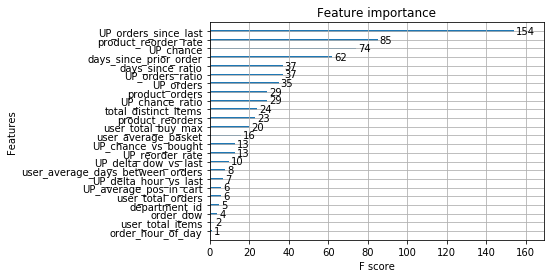

In [13]:
plot_importance(model)

In [14]:
feature_importances = pd.DataFrame(model.feature_importances_, index = df_train_var.columns, columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
UP_orders_since_last,0.220000
product_reorder_rate,0.121429
UP_chance,0.105714
days_since_prior_order,0.088571
UP_orders_ratio,0.052857
days_since_ratio,0.052857
UP_orders,0.050000
UP_chance_ratio,0.041429
product_orders,0.041429
total_distinct_items,0.034286


In [15]:
del orders
del products
gc.collect()

118

**Model after finding best features and parameters**

In [16]:
impfea = feature_importances.nlargest(7,'importance').index.values
d_train = xgb.DMatrix(df_train_var[impfea], labels_train_train)
xgb_params = {
            "objective"         : "binary:logistic"
            ,"eval_metric"      : "auc"
            ,"eta"              : 0.75
            ,"max_depth"        : 5
            ,"min_child_weight" : 7
            ,"gamma"            : 0.25
            ,"subsample"        : 1
            ,"colsample_bytree" : 0.75
            ,"alpha"            : 0.1
            ,"lambda"           : 100
        }

print('model training')
bst = xgb.train(params=xgb_params, dtrain=d_train)

print('predict on the test set')
preds = bst.predict(xgb.DMatrix(df_test_var[impfea]))

df_train_test_copy = df_train_test
df_train_test_copy['pred'] = preds

d = dict()
for row in df_train_test_copy.itertuples():
    if row.pred > 0.175:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in train_test.order_id:
    if order not in d:
        d[order] = 'None'

sub = pd.DataFrame.from_dict(d, orient='index')

sub.reset_index(inplace=True)
sub.columns = ['order_id', 'products']

df_train_test_copy['true'] = labels_train_test

e = dict()
for row in df_train_test_copy.itertuples():
    if row.true == 1:
        try:
            e[row.order_id] += ' ' + str(row.product_id)
        except:
            e[row.order_id] = str(row.product_id)

for order in train_test.order_id:
    if order not in e:
        d[order] = 'None'

sub_true = pd.DataFrame.from_dict(e, orient='index')

sub_true.reset_index(inplace=True)

sub_true.columns = ['order_id', 'true']
    
sub_merge = pd.merge(sub_true, sub, how = 'inner', on = 'order_id')
 
print('Finding Accuracy')   
res = list()
for entry in sub_merge.itertuples():
    res.append(eval_fun(entry[2], entry[3]))
res = pd.DataFrame(np.array(res), columns=['precision', 'recall', 'f1'])
print('Best f1 score:', np.mean(res['f1']))


model training
[16:38:34] Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[16:38:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[16:38:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[16:39:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[16:39:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:39:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[16:39:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[16:39:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 r

**Running the model for test data**

In [17]:
impfea = feature_importances.nlargest(7,'importance').index.values
d_train = xgb.DMatrix(df_train_var[impfea], labels_train_train)
xgb_params = {
            "objective"         : "binary:logistic"
            ,"eval_metric"      : "auc"
            ,"eta"              : 0.75
            ,"max_depth"        : 5
            ,"min_child_weight" : 7
            ,"gamma"            : 0.25
            ,"subsample"        : 1
            ,"colsample_bytree" : 0.75
            ,"alpha"            : 0.1
            ,"lambda"           : 100
        }

print('model training')
bst = xgb.train(params=xgb_params, dtrain=d_train)

print('predict on the test set')
preds = bst.predict(xgb.DMatrix(df_test[impfea]))

df_test['pred'] = preds

d = dict()
for row in df_test.itertuples():
    if row.pred > 0.175:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in test_orders.order_id:
    if order not in d:
        d[order] = 'None'

sub = pd.DataFrame.from_dict(d, orient='index')

sub.reset_index(inplace=True)
sub.columns = ['order_id', 'products']
sub.to_csv('sub_xgb.csv', index=False)

model training
[16:40:25] Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[16:40:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[16:40:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[16:40:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[16:41:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:41:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[16:41:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[16:41:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 r

In [18]:
sub.head()

,order_id,products
0,2774568,17668 21903 39190 47766 18599 43961 23650 24810
1,1528013,8424 21903 38293
2,1376945,33572 17706 28465 27959 44632 24799 34658 1494...
3,1356845,11520 14992 49683 30489 7076 22959 37687 28134...
4,2161313,11266 196 10441 12427 37710 14715 27839
